In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf 
from tensorflow.keras import models,layers
from IPython.display import HTML

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch)
    print(label_batch)

(32, 256, 256, 3)
tf.Tensor(
[[[[142. 116. 117.]
   [137. 111. 112.]
   [107.  81.  82.]
   ...
   [173. 155. 151.]
   [182. 164. 160.]
   [196. 178. 174.]]

  [[138. 112. 113.]
   [137. 111. 112.]
   [132. 106. 107.]
   ...
   [175. 157. 153.]
   [177. 159. 155.]
   [185. 167. 163.]]

  [[117.  91.  92.]
   [112.  86.  87.]
   [144. 118. 119.]
   ...
   [176. 158. 154.]
   [176. 158. 154.]
   [181. 163. 159.]]

  ...

  [[107.  81.  80.]
   [146. 120. 119.]
   [126. 100.  99.]
   ...
   [163. 143. 142.]
   [167. 147. 146.]
   [171. 151. 150.]]

  [[115.  89.  88.]
   [124.  98.  97.]
   [160. 134. 133.]
   ...
   [161. 141. 140.]
   [165. 145. 144.]
   [169. 149. 148.]]

  [[116.  90.  89.]
   [136. 110. 109.]
   [137. 111. 110.]
   ...
   [158. 138. 137.]
   [161. 141. 140.]
   [164. 144. 143.]]]


 [[[169. 155. 154.]
   [138. 124. 123.]
   [163. 149. 148.]
   ...
   [136. 110. 109.]
   [142. 116. 115.]
   [128. 102. 101.]]

  [[167. 153. 152.]
   [152. 138. 137.]
   [148. 134. 133.]

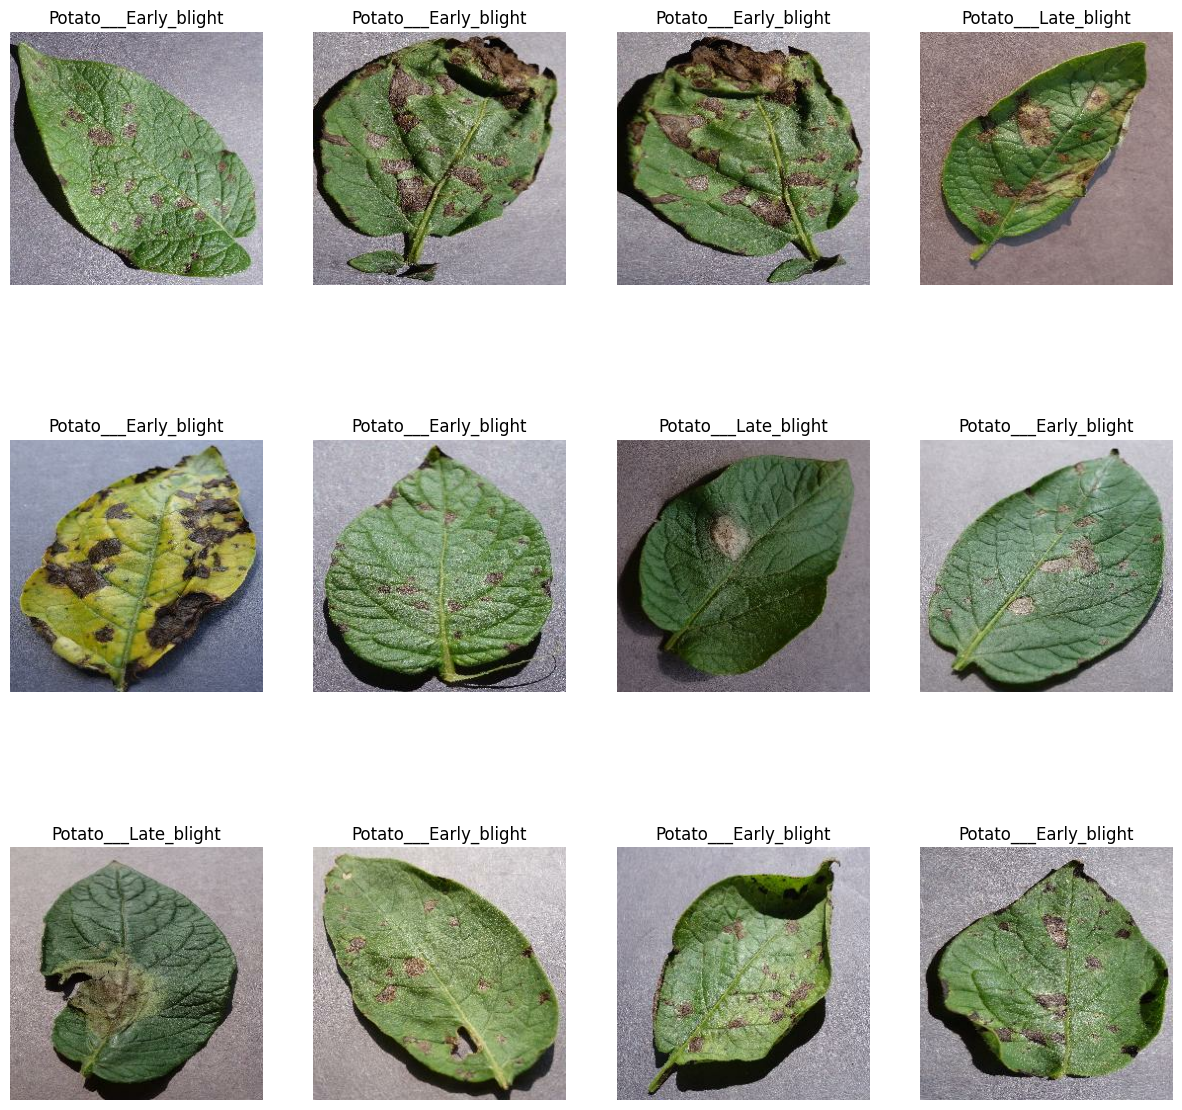

In [6]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
plt.show()

In [7]:
len(dataset)

68

In [8]:
68*32

2176

In [9]:
def get_train_partitions_df(ds,train_size=0.8,test_size=0.1,val_size=0.1,shuffle=True,shuffle_size=1000):
    assert (train_size+test_size+val_size)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(ds_size*train_size)
    val_size=int(ds_size*test_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds=get_train_partitions_df(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(test_ds)

8

In [13]:
len(val_ds)

6

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
train_ds=train_ds.map(
    lambda x,y : (data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
len(train_ds)

54

In [19]:
for x, y in train_ds.take(1):
    print(x.shape, y)

(32, 256, 256, 3) tf.Tensor([1 1 0 0 2 0 1 0 2 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0], shape=(32,), dtype=int32)


In [20]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [23]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1)

Epoch 1/50
54/54 [==============================] - 24s 316ms/step - loss: 0.8984 - accuracy: 0.5035 - val_loss: 0.7804 - val_accuracy: 0.6250
Epoch 2/50
54/54 [==============================] - 15s 269ms/step - loss: 0.5820 - accuracy: 0.7454 - val_loss: 0.5255 - val_accuracy: 0.8073
Epoch 3/50
54/54 [==============================] - 15s 274ms/step - loss: 0.3607 - accuracy: 0.8472 - val_loss: 0.3328 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 15s 278ms/step - loss: 0.2517 - accuracy: 0.9080 - val_loss: 0.1999 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 15s 274ms/step - loss: 0.2212 - accuracy: 0.9132 - val_loss: 0.1772 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 15s 270ms/step - loss: 0.2021 - accuracy: 0.9236 - val_loss: 0.2577 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 15s 274ms/step - loss: 0.1890 - accuracy: 0.9196 - val_loss: 0.1332 - val_accuracy: 0.9375

In [24]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 53ms/step - loss: 0.0694 - accuracy: 0.9883


In [25]:
scores

[0.06942111253738403, 0.98828125]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.history['loss'][:5]

[0.8983752131462097,
 0.5819578170776367,
 0.36066147685050964,
 0.25169163942337036,
 0.2211819887161255]

In [30]:
loss=history.history['loss']
val_loss=history.history['val_loss']
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

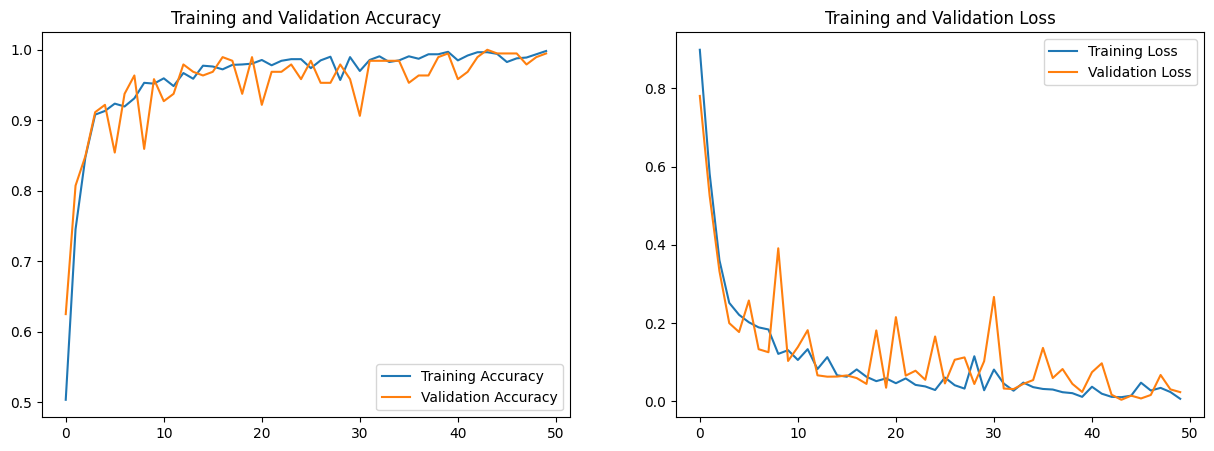

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

actual label: Potato___Late_blight
1/1 [==============================] - 0s 263ms/step
predicted label:Potato___Late_blight


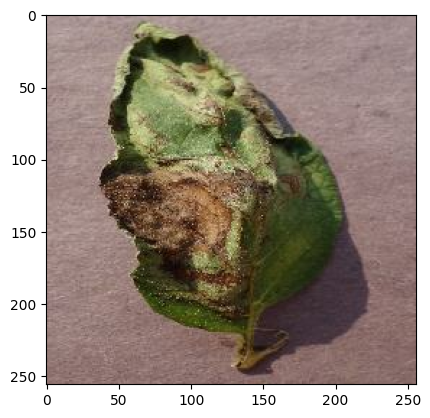

In [32]:
for x,y in test_ds.take(1):
    first_img=x[0].numpy().astype('uint8')
    first_label=y[0].numpy()
    plt.imshow(first_img)
    print(f"actual label: {class_names[first_label]}")
    pred=model.predict(x)
    print(f"predicted label:{class_names[np.argmax(pred[0])]}")


In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


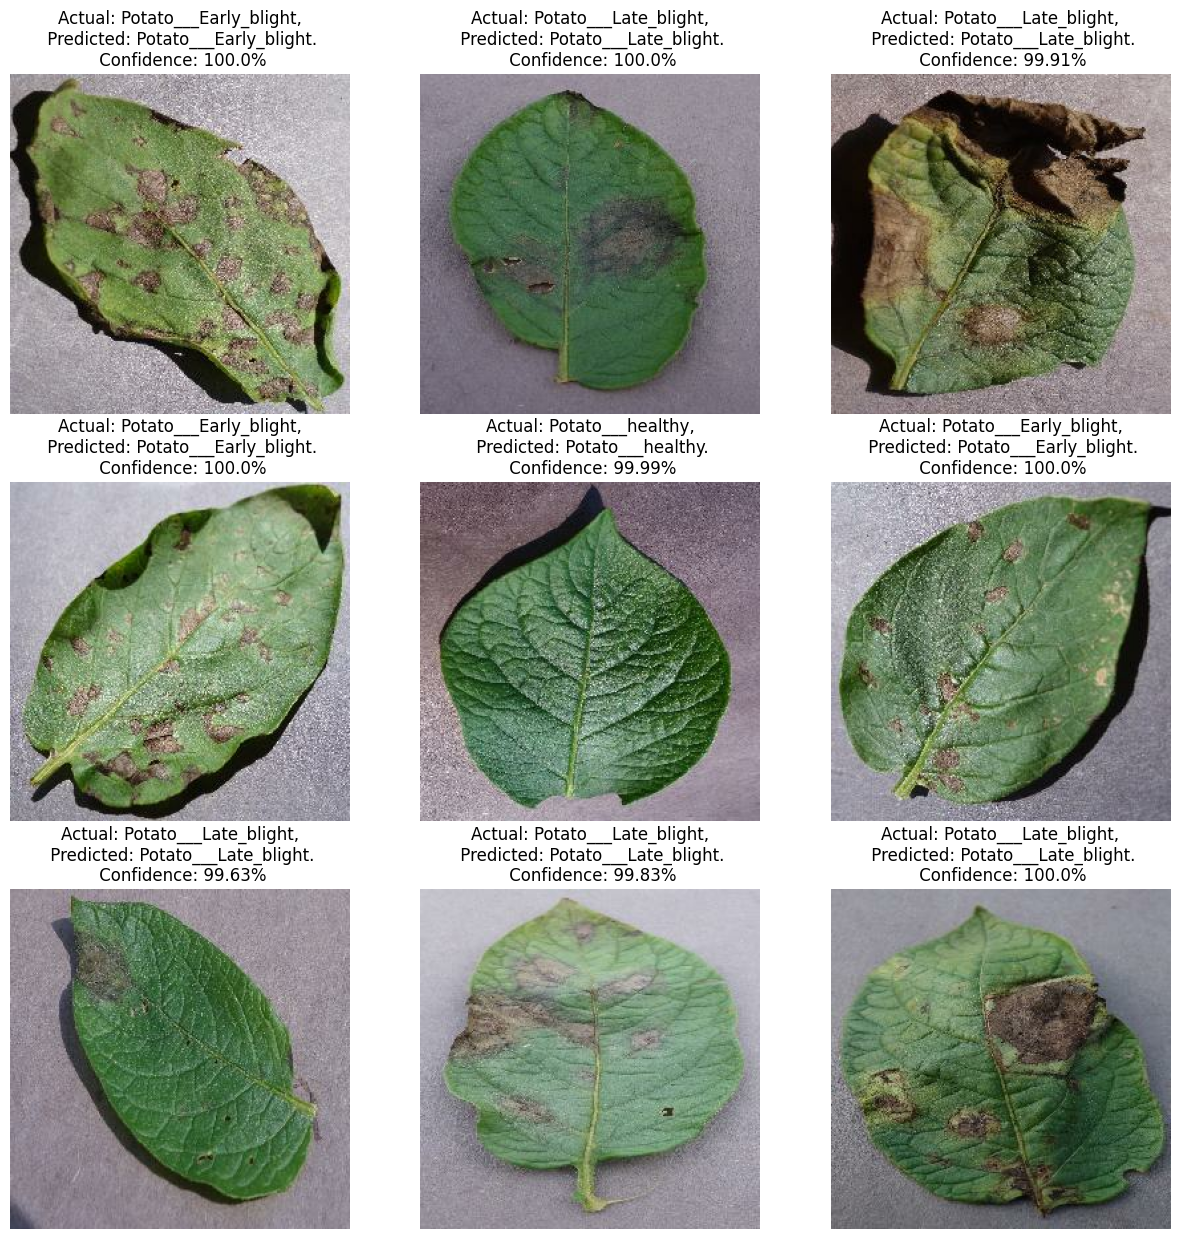

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
model_version=1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets
